In [7]:
import tensorflow as tf
print(tf.__version__)

2.7.0


# Validation, regularisation and callbacks

 ## Coding tutorials
 #### [1. Validation sets](#coding_tutorial_1)
 #### [2. Model regularisation](#coding_tutorial_2)
 #### [3. Introduction to callbacks](#coding_tutorial_3)
 #### [4. Early stopping / patience](#coding_tutorial_4)

***
<a id="coding_tutorial_1"></a>
## Validation sets

#### Load the data

In [8]:
# Load the diabetes dataset
from sklearn.datasets import load_diabetes

diabates_dataset = load_diabetes()
print(diabates_dataset["DESCR"])

# First 10 columns are numeric predictive values

.. _diabetes_dataset:

Diabetes dataset
----------------

Ten baseline variables, age, sex, body mass index, average blood
pressure, and six blood serum measurements were obtained for each of n =
442 diabetes patients, as well as the response of interest, a
quantitative measure of disease progression one year after baseline.

**Data Set Characteristics:**

  :Number of Instances: 442

  :Number of Attributes: First 10 columns are numeric predictive values

  :Target: Column 11 is a quantitative measure of disease progression one year after baseline

  :Attribute Information:
      - age     age in years
      - sex
      - bmi     body mass index
      - bp      average blood pressure
      - s1      tc, total serum cholesterol
      - s2      ldl, low-density lipoproteins
      - s3      hdl, high-density lipoproteins
      - s4      tch, total cholesterol / HDL
      - s5      ltg, possibly log of serum triglycerides level
      - s6      glu, blood sugar level

Note: Each of these 1

In [9]:
# Save the input and target variables

print(diabates_dataset.keys())

data = diabates_dataset["data"]
targets = diabates_dataset['target']

dict_keys(['data', 'target', 'frame', 'DESCR', 'feature_names', 'data_filename', 'target_filename', 'data_module'])


In [10]:
# Normalise the target data (this will make clearer training curves)
print(targets)

targets = (targets - targets.mean(axis=0)) / targets.std()

[151.  75. 141. 206. 135.  97. 138.  63. 110. 310. 101.  69. 179. 185.
 118. 171. 166. 144.  97. 168.  68.  49.  68. 245. 184. 202. 137.  85.
 131. 283. 129.  59. 341.  87.  65. 102. 265. 276. 252.  90. 100.  55.
  61.  92. 259.  53. 190. 142.  75. 142. 155. 225.  59. 104. 182. 128.
  52.  37. 170. 170.  61. 144.  52. 128.  71. 163. 150.  97. 160. 178.
  48. 270. 202. 111.  85.  42. 170. 200. 252. 113. 143.  51.  52. 210.
  65. 141.  55. 134.  42. 111.  98. 164.  48.  96.  90. 162. 150. 279.
  92.  83. 128. 102. 302. 198.  95.  53. 134. 144. 232.  81. 104.  59.
 246. 297. 258. 229. 275. 281. 179. 200. 200. 173. 180.  84. 121. 161.
  99. 109. 115. 268. 274. 158. 107.  83. 103. 272.  85. 280. 336. 281.
 118. 317. 235.  60. 174. 259. 178. 128.  96. 126. 288.  88. 292.  71.
 197. 186.  25.  84.  96. 195.  53. 217. 172. 131. 214.  59.  70. 220.
 268. 152.  47.  74. 295. 101. 151. 127. 237. 225.  81. 151. 107.  64.
 138. 185. 265. 101. 137. 143. 141.  79. 292. 178.  91. 116.  86. 122.
  72. 

In [11]:
# Split the data into train and test sets

from sklearn.model_selection import train_test_split

train_data, test_data, train_targets, test_targets = train_test_split(data, targets, test_size = 0.1)

print(train_data.shape)
print(test_data.shape)
print(train_targets.shape)
print(test_targets.shape)

(397, 10)
(45, 10)
(397,)
(45,)


#### Train a feedforward neural network model

In [12]:
# Build the model

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

def get_model():
    model = Sequential([
            Dense(128, activation="relu", input_shape=(train_data.shape[1],)),
            Dense(128, activation="relu"),
            Dense(128, activation="relu"),
            Dense(128, activation="relu"),
            Dense(128, activation="relu"),
            Dense(128, activation="relu"),
            Dense(1)
    ])
    return model

model = get_model()

In [13]:
# Print the model summary

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 128)               1408      
                                                                 
 dense_1 (Dense)             (None, 128)               16512     
                                                                 
 dense_2 (Dense)             (None, 128)               16512     
                                                                 
 dense_3 (Dense)             (None, 128)               16512     
                                                                 
 dense_4 (Dense)             (None, 128)               16512     
                                                                 
 dense_5 (Dense)             (None, 128)               16512     
                                                                 
 dense_6 (Dense)             (None, 1)                 1

In [14]:
# Compile the model

model.compile(optimizer="adam", loss="mse", metrics=["mae"])

In [15]:
# Train the model, with some of the data reserved for validation

history = model.fit(train_data, train_targets, epochs=100, validation_split=0.15, batch_size=64, verbose=False)

In [16]:
# Evaluate the model on the test set

model.evaluate(test_data, test_targets, verbose=2)

2/2 - 0s - loss: 0.5224 - mae: 0.5285 - 20ms/epoch - 10ms/step


[0.5223631262779236, 0.5285412073135376]

#### Plot the learning curves

In [17]:
import matplotlib.pyplot as plt
%matplotlib inline

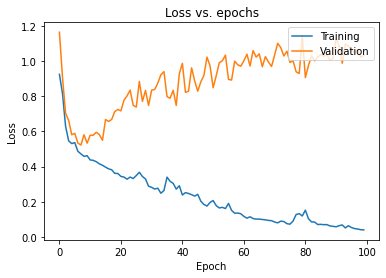

In [18]:
# Plot the training and validation loss

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss vs. epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show()

***
<a id="coding_tutorial_2"></a>
## Model regularisation

#### Adding regularisation with weight decay and dropout

In [19]:
from tensorflow.keras.layers import Dropout
from tensorflow.keras import regularizers

In [20]:
def get_regularised_model(wd, rate):
    model = Sequential([
        Dense(128, kernel_regularizer=regularizers.l2(wd), activation="relu", input_shape=(train_data.shape[1],)),
        Dropout(rate),
        Dense(128, kernel_regularizer=regularizers.l2(wd), activation="relu"),
        Dropout(rate),
        Dense(128, kernel_regularizer=regularizers.l2(wd), activation="relu"),
        Dropout(rate),
        Dense(128, kernel_regularizer=regularizers.l2(wd), activation="relu"),
        Dropout(rate),
        Dense(128, kernel_regularizer=regularizers.l2(wd), activation="relu"),
        Dropout(rate),
        Dense(128, kernel_regularizer=regularizers.l2(wd), activation="relu"),
        Dropout(rate),
        Dense(1)
    ])
    return model

In [21]:
# Re-build the model with weight decay and dropout layers

model = get_regularised_model(1e-5, 0.3)

In [22]:
# Compile the model

model.compile(optimizer="adam", loss="mse", metrics=["mae"])

In [23]:
# Train the model, with some of the data reserved for validation

history = model.fit(train_data, train_targets, epochs=100, validation_split=0.15, batch_size=64, verbose=False)

In [24]:
# Evaluate the model on the test set

model.evaluate(test_data, test_targets, verbose=2)

2/2 - 0s - loss: 0.3718 - mae: 0.4670 - 19ms/epoch - 9ms/step


[0.3718322813510895, 0.466972678899765]

#### Plot the learning curves

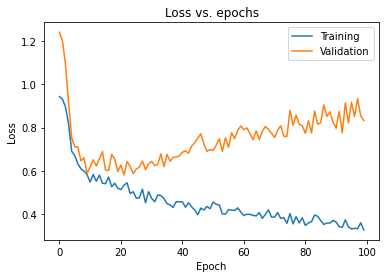

In [25]:
# Plot the training and validation loss

import matplotlib.pyplot as plt

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss vs. epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show()

# Batch normalisation layers

### Batch normalisation - Defining the model

We can implement batch normalisation into our model by adding it in the same way as any other layer.

In [26]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Conv2D, MaxPooling2D, BatchNormalization, Dropout

In [27]:
# Build the model

BN_model = Sequential([
        Dense(64, input_shape=[train_data.shape[1],], activation="relu"),
        BatchNormalization(),  # <- Batch normalisation layer
        Dropout(0.5),
        BatchNormalization(),  # <- Batch normalisation layer
        Dropout(0.5),
        Dense(256, activation='relu'),
])

# NB: We have not added the output layer because we still have more layers to add!

In [28]:
BN_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_14 (Dense)            (None, 64)                704       
                                                                 
 batch_normalization (BatchN  (None, 64)               256       
 ormalization)                                                   
                                                                 
 dropout_6 (Dropout)         (None, 64)                0         
                                                                 
 batch_normalization_1 (Batc  (None, 64)               256       
 hNormalization)                                                 
                                                                 
 dropout_7 (Dropout)         (None, 64)                0         
                                                                 
 dense_15 (Dense)            (None, 256)              

Recall that there are some parameters and hyperparameters associated with batch normalisation.

* The hyperparameter **momentum** is the weighting given to the previous running mean when re-computing it with an extra minibatch. By **default**, it is set to 0.99.

* The hyperparameter **$\epsilon$** is used for numeric stability when performing the normalisation over the minibatch. By **default** it is set to 0.001.

* The parameters **$\beta$** and **$\gamma$** are used to implement an affine transformation after normalisation. By **default**, $\beta$ is an all-zeros vector, and $\gamma$ is an all-ones vector.

### Customising parameters
These can all be changed (along with various other properties) by adding optional arguments to `tf.keras.layers.BatchNormalization()`.

We can also specify the axis for batch normalisation. By default, it is set as -1.

Let's see an example.

In [29]:
BN_model.add(tf.keras.layers.BatchNormalization(
    momentum=0.95, 
    epsilon=0.005,
    axis = -1,
    beta_initializer=tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.05), 
    gamma_initializer=tf.keras.initializers.Constant(value=0.9)
))

In [30]:
BN_model.add(Dense(1))

In [31]:
BN_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_14 (Dense)            (None, 64)                704       
                                                                 
 batch_normalization (BatchN  (None, 64)               256       
 ormalization)                                                   
                                                                 
 dropout_6 (Dropout)         (None, 64)                0         
                                                                 
 batch_normalization_1 (Batc  (None, 64)               256       
 hNormalization)                                                 
                                                                 
 dropout_7 (Dropout)         (None, 64)                0         
                                                                 
 dense_15 (Dense)            (None, 256)              

In [32]:
BN_model.compile(optimizer='adam',
                loss='mse',
                metrics=['mae'])

In [33]:
BN_history = BN_model.fit(train_data, train_targets, epochs=100, validation_split=0.15, batch_size=64,verbose=False)

In [34]:
BN_model.evaluate(test_data, test_targets, verbose=2)

2/2 - 0s - loss: 0.5256 - mae: 0.6159 - 18ms/epoch - 9ms/step


[0.5256255865097046, 0.6159117221832275]

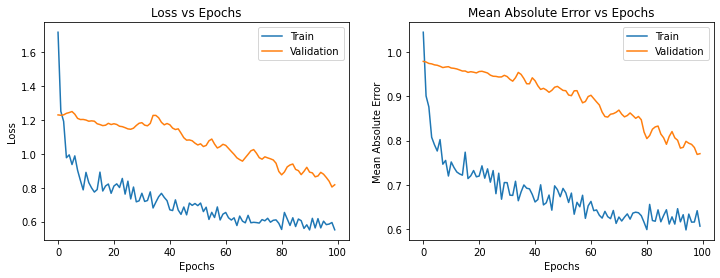

In [35]:
# Plot the learning curves

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

frame = pd.DataFrame(BN_history.history)
epochs = np.arange(len(frame))

fig = plt.figure(figsize=(12,4))

# Loss plot
ax = fig.add_subplot(121)
ax.plot(epochs, frame['loss'], label="Train")
ax.plot(epochs, frame['val_loss'], label="Validation")
ax.set_xlabel("Epochs")
ax.set_ylabel("Loss")
ax.set_title("Loss vs Epochs")
ax.legend()

# Accuracy plot
ax = fig.add_subplot(122)
ax.plot(epochs, frame['mae'], label="Train")
ax.plot(epochs, frame['val_mae'], label="Validation")
ax.set_xlabel("Epochs")
ax.set_ylabel("Mean Absolute Error")
ax.set_title("Mean Absolute Error vs Epochs")
ax.legend()

## Further reading and resources 
* https://keras.io/layers/normalization/
* https://www.tensorflow.org/versions/r2.0/api_docs/python/tf/keras/layers/BatchNormalization

***
<a id="coding_tutorial_3"></a>
## Introduction to callbacks

#### Example training callback

In [47]:
# Write a custom callback

from tensorflow.keras.callbacks import Callback

class TrainCallback(Callback):

    def on_train_begin(self, logs=None):
        print("Starting training....")

    def on_epoch_begin(self, epoch, logs=None):
        print(f"Starting epoch {epoch}")
    
    def on_train_batch_begin(self, batch, logs=None):
        print(f"Training: Starting batch {batch}")

    def on_train_batch_end(self, batch, logs=None):
        print(f"Training: Finishing batch {batch}")

    def on_epoch_end(self, epoch, logs=None):
        print(f"Finished epoch {epoch}")
    
    def on_train_end(self, logs=None):
        print("Finished training")

In [51]:
class TestingCallback(Callback):

    def on_test_begin(self, logs=None):
        print("Starting testing....")
    
    def on_test_batch_begin(self, batch, logs=None):
        print(f"Testing: Starting batch {batch}")

    def on_test_batch_end(self, batch, logs=None):
        print(f"Testing: Finishing batch {batch}")
    
    def on_test_end(self, logs=None):
        print("Finished testing")

In [53]:
class PredictionCallback(Callback):

    def on_predict_begin(self, logs=None):
        print("Starting prediction....")
    
    def on_predict_batch_begin(self, batch, logs=None):
        print(f"Prediction: Starting batch {batch}")

    def on_predict_batch_end(self, batch, logs=None):
        print(f"Prediction: Finishing batch {batch}")
    
    def on_predict_end(self, logs=None):
        print("Finished prediction!")

In [48]:
# Re-build the model

model = get_regularised_model(1e-5, 0.3)

In [49]:
# Compile the model

model.compile(optimizer="adam", loss="mse", metrics=["mae"])

#### Train the model with the callback

In [50]:
# Train the model, with some of the data reserved for validation

history = model.fit(train_data, train_targets, epochs=3, batch_size=128, verbose=False, callbacks=[TrainCallback()])

Starting training....
Starting epoch 0
Training: Starting batch 0
Training: Finishing batch 0
Training: Starting batch 1
Training: Finishing batch 1
Training: Starting batch 2
Training: Finishing batch 2
Training: Starting batch 3
Training: Finishing batch 3
Finished epoch 0
Starting epoch 1
Training: Starting batch 0
Training: Finishing batch 0
Training: Starting batch 1
Training: Finishing batch 1
Training: Starting batch 2
Training: Finishing batch 2
Training: Starting batch 3
Training: Finishing batch 3
Finished epoch 1
Starting epoch 2
Training: Starting batch 0
Training: Finishing batch 0
Training: Starting batch 1
Training: Finishing batch 1
Training: Starting batch 2
Training: Finishing batch 2
Training: Starting batch 3
Training: Finishing batch 3
Finished epoch 2
Finished training


In [52]:
# Evaluate the model

model.evaluate(test_data, test_targets, verbose=False, callbacks=[TestingCallback()])

Starting testing....
Testing: Starting batch 0
Testing: Finishing batch 0
Testing: Starting batch 1
Testing: Finishing batch 1
Finished testing


[1.0473815202713013, 0.8647701740264893]

In [54]:
# Make predictions with the model

model.predict(test_data,verbose=False, callbacks=[PredictionCallback()])

Starting prediction....
Prediction: Starting batch 0
Prediction: Finishing batch 0
Prediction: Starting batch 1
Prediction: Finishing batch 1
Finished prediction!


array([[ 0.0529097 ],
       [-0.02497783],
       [-0.06094264],
       [ 0.01422227],
       [ 0.06404117],
       [ 0.00599455],
       [-0.07720571],
       [-0.09858405],
       [ 0.02678006],
       [ 0.02668676],
       [-0.10512972],
       [-0.14079165],
       [ 0.06189184],
       [ 0.02293056],
       [-0.0797957 ],
       [-0.10515634],
       [-0.09617535],
       [-0.03546403],
       [ 0.02926412],
       [-0.07418323],
       [ 0.01398238],
       [-0.12717126],
       [-0.14071375],
       [-0.00464491],
       [-0.14738846],
       [ 0.03447799],
       [-0.08456566],
       [ 0.0656755 ],
       [ 0.01026323],
       [-0.10489138],
       [ 0.04702917],
       [-0.08342298],
       [-0.01648685],
       [-0.05389473],
       [-0.06445672],
       [-0.01655207],
       [ 0.01963482],
       [ 0.04865888],
       [ 0.05355951],
       [-0.03869712],
       [-0.01851852],
       [-0.0694853 ],
       [-0.02731466],
       [ 0.04846257],
       [-0.01240403]], dtype=flo

# Using the logs dictionary

In this reading, we will learn how to take advantage of the `logs` dictionary in Keras to define our own callbacks and check the progress of a model.

The `logs` dictionary stores the loss value, along with all of the metrics we are using at the end of a batch or epoch.

We can incorporate information from the `logs` dictionary into our own custom callbacks.

Let's see this in action in the context of a model we will construct and fit to the `sklearn` diabetes dataset that we have been using in this module.

Let's first import the dataset, and split it into the training and test sets.

In [55]:
Logs_model = tf.keras.Sequential([
        Dense(128, activation='relu', input_shape=(train_data.shape[1],)),
        Dense(64,activation='relu'),
        tf.keras.layers.BatchNormalization(),
        Dense(64, activation='relu'),
        Dense(64, activation='relu'),
        Dense(1)        
])

In [56]:
Logs_model.compile(loss='mse', optimizer="adam", metrics=['mae'])

In [57]:
class LossAndMetricCallback(tf.keras.callbacks.Callback):

    # Print the loss after every second batch in the training set
    def on_train_batch_end(self, batch, logs=None):
        if batch %2 ==0:
            print('\n After batch {}, the loss is {:7.2f}.'.format(batch, logs['loss']))
    
    # Print the loss after each batch in the test set
    def on_test_batch_end(self, batch, logs=None):
        print('\n After batch {}, the loss is {:7.2f}.'.format(batch, logs['loss']))

    # Print the loss and mean absolute error after each epoch
    def on_epoch_end(self, epoch, logs=None):
        print('Epoch {}: Average loss is {:7.2f}, mean absolute error is {:7.2f}.'.format(epoch, logs['loss'], logs['mae']))
    
    # Notify the user when prediction has finished on each batch
    def on_predict_batch_end(self,batch, logs=None):
        print("Finished prediction on batch {}!".format(batch))

In [58]:
# Train the model
history = Logs_model.fit(train_data, train_targets, epochs=20,
                         batch_size=100, callbacks=[LossAndMetricCallback()], verbose=False)


 After batch 0, the loss is    0.99.

 After batch 2, the loss is    1.00.
Epoch 0: Average loss is    0.96, mean absolute error is    0.83.

 After batch 0, the loss is    0.81.

 After batch 2, the loss is    0.71.
Epoch 1: Average loss is    0.70, mean absolute error is    0.71.

 After batch 0, the loss is    0.72.

 After batch 2, the loss is    0.60.
Epoch 2: Average loss is    0.59, mean absolute error is    0.63.

 After batch 0, the loss is    0.54.

 After batch 2, the loss is    0.54.
Epoch 3: Average loss is    0.53, mean absolute error is    0.59.

 After batch 0, the loss is    0.57.

 After batch 2, the loss is    0.48.
Epoch 4: Average loss is    0.48, mean absolute error is    0.56.

 After batch 0, the loss is    0.46.

 After batch 2, the loss is    0.46.
Epoch 5: Average loss is    0.46, mean absolute error is    0.55.

 After batch 0, the loss is    0.43.

 After batch 2, the loss is    0.42.
Epoch 6: Average loss is    0.43, mean absolute error is    0.53.

 Afte

In [59]:
# Evaluate the model

model_eval = Logs_model.evaluate(test_data, test_targets, batch_size=10, 
                                 callbacks=[LossAndMetricCallback()], verbose=False)


 After batch 0, the loss is    1.17.

 After batch 1, the loss is    1.26.

 After batch 2, the loss is    1.06.

 After batch 3, the loss is    1.09.

 After batch 4, the loss is    1.00.


In [60]:
# Get predictions from the model

model_pred = Logs_model.predict(test_data, batch_size=10,
                                callbacks=[LossAndMetricCallback()], verbose=False)

Finished prediction on batch 0!
Finished prediction on batch 1!
Finished prediction on batch 2!
Finished prediction on batch 3!
Finished prediction on batch 4!


### Application - learning rate scheduler
Let's now look at a more sophisticated custom callback. 

We are going to define a callback to change the learning rate of the optimiser of a model during training. We will do this by specifying the epochs and new learning rates where we would like it to be changed.

First we define the auxillary function that returns the learning rate for each epoch based on our schedule.

In [61]:
# Define the learning rate schedule. The tuples below are (start_epoch, new_learning_rate)

lr_schedule = [
    (4, 0.03), (7, 0.02), (11, 0.005), (15, 0.007)
]

def get_new_epoch_lr(epoch, lr):
    # Checks to see if the input epoch is listed in the learning rate schedule 
    # and if so, returns index in lr_schedule
    epoch_in_sched = [i for i in range(len(lr_schedule)) if lr_schedule[i][0]==int(epoch)]
    if len(epoch_in_sched)>0:
        # If it is, return the learning rate corresponding to the epoch
        return lr_schedule[epoch_in_sched[0]][1]
    else:
        # Otherwise, return the existing learning rate
        return lr

In [62]:
# Define the custom callback

class LRScheduler(tf.keras.callbacks.Callback):
    
    def __init__(self, new_lr):
        super(LRScheduler, self).__init__()
        # Add the new learning rate function to our callback
        self.new_lr = new_lr

    def on_epoch_begin(self, epoch, logs=None):
        # Make sure that the optimizer we have chosen has a learning rate, and raise an error if not
        if not hasattr(self.model.optimizer, 'lr'):
              raise ValueError('Error: Optimizer does not have a learning rate.')
                
        # Get the current learning rate
        curr_rate = float(tf.keras.backend.get_value(self.model.optimizer.lr))
        
        # Call the auxillary function to get the scheduled learning rate for the current epoch
        scheduled_rate = self.new_lr(epoch, curr_rate)

        # Set the learning rate to the scheduled learning rate
        tf.keras.backend.set_value(self.model.optimizer.lr, scheduled_rate)
        print('Learning rate for epoch {} is {:7.3f}'.format(epoch, scheduled_rate))

In [63]:
new_Logs_model = tf.keras.Sequential([
            Dense(128, activation='relu', input_shape=(train_data.shape[1],)),
            Dense(64,activation='relu'),
            tf.keras.layers.BatchNormalization(),
            Dense(64, activation='relu'),
            Dense(64, activation='relu'),
            Dense(1)        
])

In [64]:
new_Logs_model.compile(loss='mse',
                    optimizer="adam",
                    metrics=['mae', 'mse'])

In [65]:
# Fit the model with our learning rate scheduler callback

new_history = new_Logs_model.fit(train_data, train_targets, epochs=20,
                                 batch_size=100, callbacks=[LRScheduler(get_new_epoch_lr)], verbose=False)

Learning rate for epoch 0 is   0.001
Learning rate for epoch 1 is   0.001
Learning rate for epoch 2 is   0.001
Learning rate for epoch 3 is   0.001
Learning rate for epoch 4 is   0.030
Learning rate for epoch 5 is   0.030
Learning rate for epoch 6 is   0.030
Learning rate for epoch 7 is   0.020
Learning rate for epoch 8 is   0.020
Learning rate for epoch 9 is   0.020
Learning rate for epoch 10 is   0.020
Learning rate for epoch 11 is   0.005
Learning rate for epoch 12 is   0.005
Learning rate for epoch 13 is   0.005
Learning rate for epoch 14 is   0.005
Learning rate for epoch 15 is   0.007
Learning rate for epoch 16 is   0.007
Learning rate for epoch 17 is   0.007
Learning rate for epoch 18 is   0.007
Learning rate for epoch 19 is   0.007


***
<a id="coding_tutorial_4"></a>
## Early stopping / patience

#### Re-train the models with early stopping

In [71]:
# Re-train the unregularised model

unregularised_model = get_model()
unregularised_model.compile(optimizer="adam", loss="mse")
unreg_history = unregularised_model.fit(train_data, train_targets, epochs=100,
                                        validation_split=0.15, batch_size=64, verbose=False,
                                        callbacks=[tf.keras.callbacks.EarlyStopping(patience=2)])

In [72]:
# Evaluate the model on the test set

unregularised_model.evaluate(test_data, test_targets, verbose=2)

2/2 - 0s - loss: 0.4252 - 28ms/epoch - 14ms/step


0.4252035319805145

In [73]:
# Re-train the regularised model

regularised_model = get_regularised_model(1e-8, 0.2)
regularised_model.compile(optimizer="adam", loss="mse")
reg_history = regularised_model.fit(train_data, train_targets, epochs=100,
                                    validation_split=0.15, batch_size=64, verbose=False,
                                    callbacks=[tf.keras.callbacks.EarlyStopping(patience=2)])

In [74]:
# Evaluate the model on the test set

regularised_model.evaluate(test_data, test_targets, verbose=2)

2/2 - 0s - loss: 0.3661 - 28ms/epoch - 14ms/step


0.3660556674003601

#### Plot the learning curves

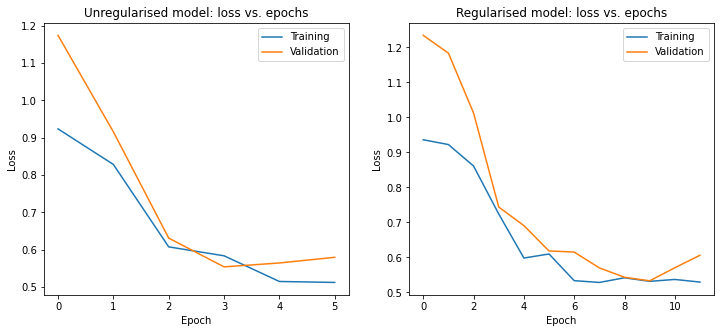

In [75]:
# Plot the training and validation loss

import matplotlib.pyplot as plt

fig = plt.figure(figsize=(12, 5))

fig.add_subplot(121)

plt.plot(unreg_history.history['loss'])
plt.plot(unreg_history.history['val_loss'])
plt.title('Unregularised model: loss vs. epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')

fig.add_subplot(122)

plt.plot(reg_history.history['loss'])
plt.plot(reg_history.history['val_loss'])
plt.title('Regularised model: loss vs. epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')

plt.show()

# Additional callbacks

In this reading we'll be looking at more of the inbuilt callbacks available in Keras.

## Learning rate scheduler

**Usage:** `tf.keras.callbacks.LearningRateScheduler(schedule, verbose=0)`

The learning rate scheduler that we implemented in the previous reading as a custom callback is also available as a built in callback. 

As in our custom callback, the `LearningRateScheduler` in Keras takes a function `schedule` as an argument. 

This function `schedule` should take two arguments:
* The current epoch (as an integer), and
* The current learning rate,

and return new learning rate for that epoch. 

The `LearningRateScheduler` also has an optional `verbose` argument, which prints information about the learning rate if it is set to 1.

Let's see a simple example.

In [76]:
# Define the learning rate schedule function

def lr_function(epoch, lr):
    if epoch % 2 == 0:
        return lr
    else:
        return lr + epoch/1000

In [77]:
# Train the model

new_history = new_Logs_model.fit(train_data, train_targets, epochs=10,
                                 callbacks=[tf.keras.callbacks.LearningRateScheduler(lr_function, verbose=1)], verbose=False)


Epoch 00001: LearningRateScheduler setting learning rate to 0.007000000216066837.

Epoch 00002: LearningRateScheduler setting learning rate to 0.008000000216066838.

Epoch 00003: LearningRateScheduler setting learning rate to 0.00800000037997961.

Epoch 00004: LearningRateScheduler setting learning rate to 0.01100000037997961.

Epoch 00005: LearningRateScheduler setting learning rate to 0.010999999940395355.

Epoch 00006: LearningRateScheduler setting learning rate to 0.015999999940395356.

Epoch 00007: LearningRateScheduler setting learning rate to 0.01600000075995922.

Epoch 00008: LearningRateScheduler setting learning rate to 0.02300000075995922.

Epoch 00009: LearningRateScheduler setting learning rate to 0.023000000044703484.

Epoch 00010: LearningRateScheduler setting learning rate to 0.032000000044703485.


In [78]:
# Train the model with a difference schedule

new_history = new_Logs_model.fit(train_data, train_targets, epochs=10,
                                 callbacks=[tf.keras.callbacks.LearningRateScheduler(lambda x:1/(3+5*x), verbose=1)], verbose=False)


Epoch 00001: LearningRateScheduler setting learning rate to 0.3333333333333333.

Epoch 00002: LearningRateScheduler setting learning rate to 0.125.

Epoch 00003: LearningRateScheduler setting learning rate to 0.07692307692307693.

Epoch 00004: LearningRateScheduler setting learning rate to 0.05555555555555555.

Epoch 00005: LearningRateScheduler setting learning rate to 0.043478260869565216.

Epoch 00006: LearningRateScheduler setting learning rate to 0.03571428571428571.

Epoch 00007: LearningRateScheduler setting learning rate to 0.030303030303030304.

Epoch 00008: LearningRateScheduler setting learning rate to 0.02631578947368421.

Epoch 00009: LearningRateScheduler setting learning rate to 0.023255813953488372.

Epoch 00010: LearningRateScheduler setting learning rate to 0.020833333333333332.


## CSV logger
**Usage** `tf.keras.callbacks.CSVLogger(filename, separator=',', append=False)`

This callback streams the results from each epoch into a CSV file.
The first line of the CSV file will be the names of pieces of information recorded on each subsequent line, beginning with the epoch and loss value. The values of metrics at the end of each epoch will also be recorded.

The only compulsory argument is the `filename` for the log to be streamed to. This could also be a filepath.

You can also specify the `separator` to be used between entries on each line.

The `append` argument allows you the option to append your results to an existing file with the same name. This can be particularly useful if you are continuing training.

Let's see an example.

In [79]:
# Train the model

new_history = new_Logs_model.fit(train_data, train_targets, epochs=10,
                                 callbacks=[tf.keras.callbacks.CSVLogger("results.csv")], verbose=False)

In [80]:
# Load the CSV

import pandas as pd

pd.read_csv("results.csv", index_col='epoch')

,loss,mae,mse
epoch,,,
0,9.996628,3.001621,9.996628
1,9.762499,2.962589,9.762499
2,9.529485,2.923482,9.529485
3,9.301835,2.883787,9.301835
4,9.070987,2.843661,9.070987
5,8.845117,2.803293,8.845117
6,8.619966,2.763122,8.619966
7,8.400034,2.722847,8.400034
8,8.180387,2.682346,8.180387


## Lambda callbacks
**Usage** `tf.keras.callbacks.LambdaCallback(
        on_epoch_begin=None, on_epoch_end=None, 
        on_batch_begin=None, on_batch_end=None, 
        on_train_begin=None, on_train_end=None)`

Lambda callbacks are used to quickly define simple custom callbacks with the use of lambda functions.

Each of the functions require some positional arguments.
* `on_epoch_begin` and `on_epoch_end` expect two arguments: `epoch` and `logs`,
* `on_batch_begin` and `on_batch_end` expect two arguments: `batch` and `logs` and
* `on_train_begin` and `on_train_end` expect one argument: `logs`.

Let's see an example of this in practice.

In [81]:
# Print the epoch number at the beginning of each epoch

epoch_callback = tf.keras.callbacks.LambdaCallback(
    on_epoch_begin=lambda epoch,logs: print('Starting Epoch {}!'.format(epoch+1)))

In [82]:
# Print the loss at the end of each batch

batch_loss_callback = tf.keras.callbacks.LambdaCallback(
    on_batch_end=lambda batch,logs: print('\n After batch {}, the loss is {:7.2f}.'.format(batch, logs['loss'])))

In [83]:
# Inform that training is finished

train_finish_callback = tf.keras.callbacks.LambdaCallback(
    on_train_end=lambda logs: print('Training finished!'))

In [84]:
# Train the model with the lambda callbacks

new_history = new_Logs_model.fit(train_data, train_targets, epochs=10,
                                 callbacks=[epoch_callback, batch_loss_callback,train_finish_callback], verbose=False)

Starting Epoch 1!

 After batch 0, the loss is    9.11.

 After batch 1, the loss is    8.50.

 After batch 2, the loss is    7.97.

 After batch 3, the loss is    7.95.

 After batch 4, the loss is    7.89.

 After batch 5, the loss is    7.82.

 After batch 6, the loss is    7.85.

 After batch 7, the loss is    7.78.

 After batch 8, the loss is    7.70.

 After batch 9, the loss is    7.66.

 After batch 10, the loss is    7.79.

 After batch 11, the loss is    7.75.

 After batch 12, the loss is    7.75.
Starting Epoch 2!

 After batch 0, the loss is    7.47.

 After batch 1, the loss is    7.42.

 After batch 2, the loss is    7.11.

 After batch 3, the loss is    7.39.

 After batch 4, the loss is    7.41.

 After batch 5, the loss is    7.59.

 After batch 6, the loss is    7.53.

 After batch 7, the loss is    7.62.

 After batch 8, the loss is    7.71.

 After batch 9, the loss is    7.66.

 After batch 10, the loss is    7.56.

 After batch 11, the loss is    7.53.

 After b

## Reduce learning rate on plateau
**Usage** `tf.keras.callbacks.ReduceLROnPlateau(
            monitor='val_loss', 
            factor=0.1, 
            patience=10, 
            verbose=0, 
            mode='auto', 
            min_delta=0.0001, 
            cooldown=0, 
            min_lr=0)`

The `ReduceLROnPlateau` callback allows reduction of the learning rate when a metric has stopped improving. 
The arguments are similar to those used in the `EarlyStopping` callback.
* The argument `monitor` is used to specify which metric to base the callback on.
* The `factor` is the factor by which the learning rate decreases i.e., new_lr=factor*old_lr.
* The `patience` is the number of epochs where there is no improvement on the monitored metric before the learning rate is reduced.
* The `verbose` argument will produce progress messages when set to 1.
* The `mode` determines whether the learning rate will decrease when the monitored quantity stops increasing (`max`) or decreasing (`min`). The `auto` setting causes the callback to infer the mode from the monitored quantity.
* The `min_delta` is the smallest change in the monitored quantity to be deemed an improvement.
* The `cooldown` is the number of epochs to wait after the learning rate is changed before the callback resumes normal operation.
* The `min_lr` is a lower bound on the learning rate that the callback will produce.

Let's examine a final example.

In [87]:
# Train the model with the ReduceLROnPlateau callback

new_history = new_Logs_model.fit(train_data, train_targets, epochs=100,
                                 callbacks=[tf.keras.callbacks.ReduceLROnPlateau(monitor="loss",factor=0.2, verbose=1)],
                                 verbose=False)


Epoch 00038: ReduceLROnPlateau reducing learning rate to 0.00416666679084301.

Epoch 00049: ReduceLROnPlateau reducing learning rate to 0.0008333333767950535.

Epoch 00059: ReduceLROnPlateau reducing learning rate to 0.00016666667070239783.

Epoch 00069: ReduceLROnPlateau reducing learning rate to 3.333333297632635e-05.

Epoch 00079: ReduceLROnPlateau reducing learning rate to 6.666666740784422e-06.

Epoch 00089: ReduceLROnPlateau reducing learning rate to 1.3333333299669903e-06.

Epoch 00099: ReduceLROnPlateau reducing learning rate to 2.666666659933981e-07.


### Further reading and resources
* https://keras.io/callbacks/
* https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/LearningRateScheduler
* https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/CSVLogger
* https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/LambdaCallback